### Univariate Hyperparameter GridSearchCV LSTM-RNN Sumatera Selatan

In [1]:
# pustaka untuk manipulasi data
import pandas as pd
from pandas import concat
from pandas import DataFrame
from pandas import read_csv
from pandas import read_excel
import numpy as np
from numpy import concatenate

# pustaka untuk waktu komputasi
import time
from datetime import datetime

# Pustaka untuk visualisasi data
import seaborn as sns # Visualization
from matplotlib import pyplot
from matplotlib import pyplot as plt

# Pustaka untuk membuat data latih dan data uji.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Pustaka untuk membuat model prediksi LSTM-RNN
import itertools
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import Adam, Adamax, RMSprop, SGD

# Early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Pustaka untuk  evaluasi model prediksi
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
# Set waktu komputasi
start = time.time()

In [3]:
# fix random seed for reproducibility
np.random.seed(7)

In [4]:
# membaca dataset
dataset = read_excel("D:/Belajar Python/dataset/dataset tesis/dataset.xlsx")

In [5]:
# set index tanggal
# dataset = dataset.set_index("tanggal")

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tanggal         240 non-null    datetime64[ns]
 1   sst             240 non-null    float64       
 2   soi             240 non-null    float64       
 3   oni             240 non-null    float64       
 4   hotspot_riau    240 non-null    int64         
 5   hotspot_sumsel  240 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 11.4 KB


In [7]:
print(dataset.head())

     tanggal   sst  soi   oni  hotspot_riau  hotspot_sumsel
0 2001-01-31 -0.83  1.6 -0.68            17               3
1 2001-02-28 -0.61  2.8 -0.52           159               5
2 2001-03-31 -0.38  1.5 -0.44           479              10
3 2001-04-30 -0.26  0.3 -0.34            45              20
4 2001-05-31 -0.25 -0.8 -0.25            81              39


### Studi Kasus Sumatera Selatan

In [8]:
# memilih area studi
df_sumsel = dataset[["hotspot_sumsel"]]
df_sumsel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   hotspot_sumsel  240 non-null    int64
dtypes: int64(1)
memory usage: 2.0 KB


In [9]:
print(df_sumsel.head())

   hotspot_sumsel
0               3
1               5
2              10
3              20
4              39


In [10]:
# ensure all data is float
df_sumsel = df_sumsel.values
df_sumsel = df_sumsel.astype('float32')

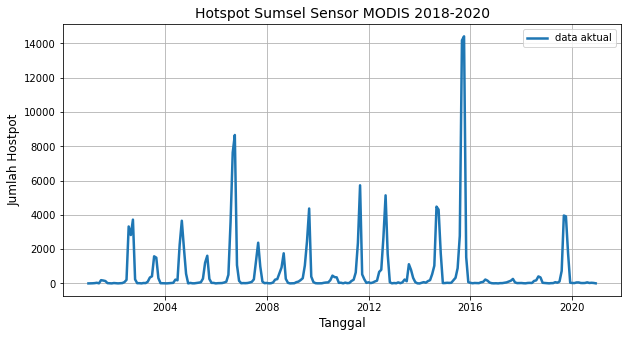

In [11]:
# generate urutan data sesuai panjang datanya
x = pd.date_range(start="2001-01-01", periods=len(df_sumsel), freq='MS')

# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(x, df_sumsel, color="tab:blue", label="data aktual", linewidth=2.5)

# membuat label-label
ax.set_title("Hotspot Sumsel Sensor MODIS 2018-2020", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

### Normalisasi Data

In [12]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
df_sumsel = scaler.fit_transform(df_sumsel)

In [13]:
np.round(df_sumsel[:5],6)

array([[-0.999723],
       [-0.999445],
       [-0.998751],
       [-0.997364],
       [-0.994728]], dtype=float32)

### Data Latih dan Data Uji

In [14]:
# split into train and test sets
train_size = int(len(df_sumsel) * 0.8)
test_size = len(df_sumsel) - train_size
train, test = df_sumsel[0:train_size,:], df_sumsel[train_size:len(df_sumsel),:]

In [15]:
print(train.shape, test.shape)

(192, 1) (48, 1)


### Supervised Learning

In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [18]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
print(trainX.shape, testX.shape)

(190, 1, 1) (46, 1, 1)


In [20]:
print(testY.shape, testY.shape)

(46,) (46,)


### Hyperparameter GridSearchCV LSTM-RNN

In [21]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [22]:
parameters = {'neurons' : [10],
              'activation' : ['sigmoid', 'tanh', 'relu', 'selu', 'elu', 'softplus'],
              'optimizer' : ['adam', 'adamax', 'rmsprop', 'sgd'],
              'dropout_rate' : [0.1, 0.2, 0.3, 0.4, 0.5],
              'epochs' : [2000],
              'batch_size' : [8, 16, 32, 64],
              'verbose' : [0]}

In [23]:
def build_classifier(neurons='', activation='', optimizer='', dropout_rate=''):
    tf.keras.backend.clear_session()
    
    # design network
    grid_model = Sequential()
    grid_model.add(LSTM(units=neurons, activation=activation, input_shape=(1, look_back)))
    grid_model.add(Dropout(dropout_rate))
    grid_model.add(Dense(1))

    # model compile
    grid_model.compile(loss='mae', optimizer=optimizer)
    
    # return value
    return grid_model

In [24]:
grid_model = KerasRegressor(build_fn=build_classifier)

In [25]:
grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters, n_jobs=-1, cv=2, scoring= 'neg_root_mean_squared_error')

In [26]:
grid_result = grid_search.fit(trainX, trainY)

In [27]:
# summarize results
print("Best parameters: %f using %s\n" % (grid_search.best_score_, grid_search.best_params_))

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best parameters: -0.210152 using {'activation': 'selu', 'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 2000, 'neurons': 10, 'optimizer': 'sgd', 'verbose': 0}

-0.226847 (0.051298) with: {'activation': 'sigmoid', 'batch_size': 8, 'dropout_rate': 0.1, 'epochs': 2000, 'neurons': 10, 'optimizer': 'adam', 'verbose': 0}
-0.254016 (0.060096) with: {'activation': 'sigmoid', 'batch_size': 8, 'dropout_rate': 0.1, 'epochs': 2000, 'neurons': 10, 'optimizer': 'adamax', 'verbose': 0}
-0.232076 (0.048202) with: {'activation': 'sigmoid', 'batch_size': 8, 'dropout_rate': 0.1, 'epochs': 2000, 'neurons': 10, 'optimizer': 'rmsprop', 'verbose': 0}
-0.270679 (0.064082) with: {'activation': 'sigmoid', 'batch_size': 8, 'dropout_rate': 0.1, 'epochs': 2000, 'neurons': 10, 'optimizer': 'sgd', 'verbose': 0}
-0.231681 (0.051529) with: {'activation': 'sigmoid', 'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 2000, 'neurons': 10, 'optimizer': 'adam', 'verbose': 0}
-0.256175 (0.061134) with: {'activation': 'sigmoid'

In [28]:
result = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["score"])],axis=1)

In [29]:
result.sort_values(by="score", ascending=False)

,activation,batch_size,dropout_rate,epochs,neurons,optimizer,verbose,score
247,selu,8,0.2,2000,10,sgd,0,-0.210152
255,selu,8,0.4,2000,10,sgd,0,-0.211129
251,selu,8,0.3,2000,10,sgd,0,-0.211602
279,selu,16,0.5,2000,10,sgd,0,-0.212043
275,selu,16,0.4,2000,10,sgd,0,-0.212621
...,...,...,...,...,...,...,...,...
161,relu,8,0.1,2000,10,adamax,0,-0.320363
200,relu,32,0.1,2000,10,adam,0,-0.324485
220,relu,64,0.1,2000,10,adam,0,-0.325033
184,relu,16,0.2,2000,10,adam,0,-0.367945


In [30]:
# result.sort_values(by="score", ascending=False).to_csv('univariate_gridsearch_lstm.csv',index=False)

### Evaluasi Model LSTM-RNN

In [31]:
# Set akhir waktu komputasi 
end = time.time()

In [32]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [33]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:38:33.77
